# Result Replication in for the paper 'Matern GP on Graphs'

This notebook we summarizes the most important results, i.e.

1. A summary of the performance reached with each model
2. Reached the reported accuracy in the paper with exact diffusion kernel (normalized / unnormalized laplacian)
3. Reached similar level of accuracy with the GRF kernel (showing exact diffusion / PoFM / GRF with different walkers)
   1. showing via gram matrix 
   2. showing via l2 error / log marginal likelihood
4. Showed superior performance when learning with arbitrary kernel (with PoFM / GRF with different walkers)

(note that for later we will simply refer PoFM as GRF with infinite walkers, instead of analysing separately)


## Setup Dependencies and Load the Datasets

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

In [5]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")

### Load and preprocess the PEMS dataset
The nasty details of the dataset preparation are hidden away in `preprocessing` module.

In [6]:
np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

In [7]:
# Load and preprocess the data
G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

# Renaming the train / test data

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(f)


epsg:4326


/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [8]:
adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

(1016, 1016)


In [9]:
def gp_training(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    
    # Explicitly set dtype to float32
    dtype = tf.float64
    # Assign Uniform prior with explicitly cast float32 values
    model.kernel.beta.prior = tfp.distributions.Uniform(
        low=tf.constant(0.0, dtype=dtype), 
        high=tf.constant(2.0, dtype=dtype)
    )
    
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return mean, stddev

## Performance Summary

TBC

## Performance of the exact Diffusion Kernel

In [12]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix, normalize_laplacian=True)
model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.beta,Parameter,Softplus,Uniform,True,(),float64,1.46909
GPR.kernel.sigma_f,Parameter,Softplus,,True,(),float64,1.27083
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.101582


In [13]:
gram_matrix_diffusion = graph_kernel.K(X_full).numpy()
det = np.linalg.det(gram_matrix_diffusion)
print('Determinant of the covariance matrix:', det)

Determinant of the covariance matrix: 2.0683296778312976e-21


In [14]:
print(f'(Train) Log marginal likelihood: {model.log_marginal_likelihood()}')

mean, cov = model.predict_f(x_test, full_cov=True)

l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
print("(Test) Relative l2 error is {}".format(l2_error))

mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
print(f"(Test) Log marginal likelihood:  {likelihood}")

(Train) Log marginal likelihood: -349.57144280424393
(Test) Relative l2 error is 1.8137098353292072
(Test) Log marginal likelihood:  -98.64286791042983


## Sanity Check: Gram Matrix

Here, we parameterise the GRF Kernels with the best hyperparam learned for diffusion kernel, and check the gram matrices.

In [10]:
WALKS_PER_NODE = 1000
P_HALT = 0.1
MAX_WALK_LENGTH = 2
SIGMA = 1

In [11]:
diffusion_learned_hyperparams = {
    'beta': model.kernel.beta.numpy(),
    'sigma_f': model.kernel.sigma_f.numpy(),
    'variance': model.likelihood.variance.numpy()
}

NameError: name 'model' is not defined

In [32]:
fros = []

# Do it for the PoFM kernel
graph_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)
model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None, noise_variance=0.01)
# model.kernel.beta.assign(diffusion_learned_hyperparams['beta'])
model.kernel.beta.assign(0.1)
# model.kernel.sigma_f.assign(diffusion_learned_hyperparams['sigma_f'])
# model.likelihood.variance.assign(diffusion_learned_hyperparams['variance'])
   
gram_matrix_pofm = graph_kernel.K(X_full).numpy()
# fro = compute_fro(gram_matrix_diffusion, gram_matrix_pofm)
# fros.append({'walks_per_node': 'PoFM', 'fro': fro})

for walks_per_node in [1,2,4,8,16,32,64,128,256]:
    # Create a new GraphDiffusionFastGRFKernel with the current walks_per_node
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=P_HALT,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               normalize_laplacian=True)
    
    # Train the GP model
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None, noise_variance=0.01)
    # model.kernel.beta.assign(diffusion_learned_hyperparams['beta'])
    model.kernel.beta.assign(0.1)
    # model.kernel.sigma_f.assign(diffusion_learned_hyperparams['sigma_f'])
    # model.likelihood.variance.assign(diffusion_learned_hyperparams['variance'])
    
    gram_matrix_grf = graph_kernel.K(X_full).numpy()
    fro = compute_fro(gram_matrix_pofm, gram_matrix_grf)
    fros.append({'walks_per_node': walks_per_node, 'fro': fro})
    


In [86]:
import numpy as np
import networkx as nx

# Generate a random graph with 10 nodes
random_graph = nx.erdos_renyi_graph(n=4, p=0.5)

# Get the adjacency matrix of the random graph
random_adjacency_matrix = nx.to_numpy_array(random_graph)

print(random_adjacency_matrix)

[[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]


In [109]:
MAX_WALK_LENGTH = 5

In [110]:
graph_kernel = GraphDiffusionFastGRFKernel(random_adjacency_matrix,
                                            walks_per_node=100000,
                                            beta=0.1,
                                            p_halt=P_HALT,
                                            max_walk_length=MAX_WALK_LENGTH+1,
                                            normalize_laplacian=True)

gram_matrix_grf = graph_kernel.grf_kernel(beta=0.1, sigma_f=1).numpy()

# gram_matrix_grf = graph_kernel.K(X_full).numpy()
gram_matrix_grf

array([[0.90719213, 0.06379309, 0.00226272, 0.        ],
       [0.06379309, 0.90933186, 0.06432761, 0.        ],
       [0.00226272, 0.06432761, 0.90742719, 0.        ],
       [0.        , 0.        , 0.        , 0.90495838]])

In [111]:
graph_kernel = GraphDiffusionPoFMKernel(random_adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)

gram_matrix_pofm = graph_kernel.compute_diffusion_kernel(adj_matrix=random_adjacency_matrix,
                                                         beta=0.1, max_expansion=MAX_WALK_LENGTH).numpy()

# gram_matrix_grf = graph_kernel.K(X_full).numpy()
gram_matrix_pofm

array([[0.9071014 , 0.06408836, 0.00226398, 0.        ],
       [0.06408836, 0.90936538, 0.06408836, 0.        ],
       [0.00226398, 0.06408836, 0.9071014 , 0.        ],
       [0.        , 0.        , 0.        , 0.90483742]])

In [39]:
gram_matrix_pofm

array([[9.07769361e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.07676453e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.08562010e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.08056998e-01, 2.07785317e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.07785317e-04, 9.08030836e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.06773565e-01]])

In [33]:
np.sqrt(np.sum((gram_matrix_grf - gram_matrix_pofm)**2 ))/ np.sqrt(np.sum((gram_matrix_pofm)**2 ))

0.010413896015760473

In [34]:
np.sort(gram_matrix_grf[0])[::-1]

array([9.14734037e-01, 1.86906046e-05, 5.25690325e-06, 3.83363551e-06,
       3.15869054e-08, 2.59913451e-08, 3.01908626e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [35]:
np.sort(gram_matrix_pofm[0])[::-1]

array([9.07769361e-01, 1.89625729e-05, 4.74678632e-06, 3.55984237e-06,
       3.35972903e-08, 2.75783609e-08, 4.82082528e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

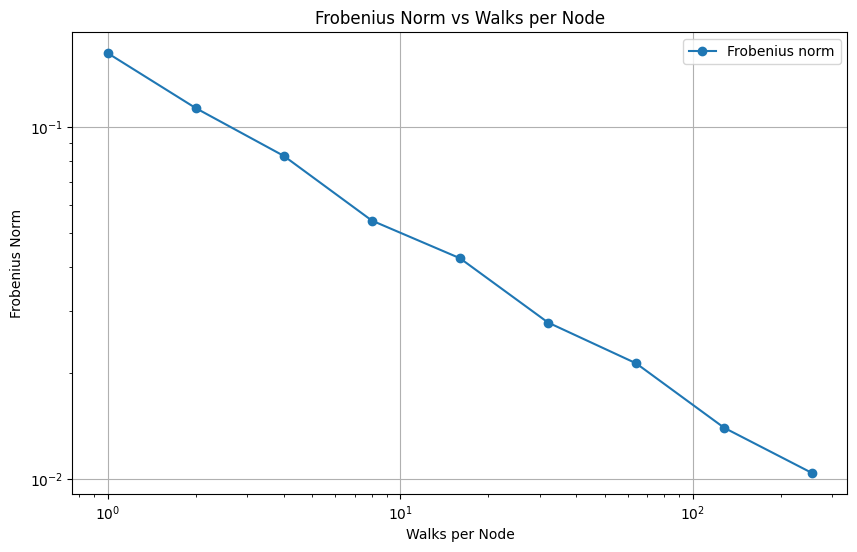

In [36]:
# Extract data for plotting
walks_per_node = [entry['walks_per_node'] for entry in fros if entry['walks_per_node'] != 'PoFM']
fro_values = [entry['fro'] for entry in fros if entry['walks_per_node'] != 'PoFM']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(walks_per_node, fro_values, marker='o', label='Frobenius norm')


# Add labels and title
plt.xlabel('Walks per Node')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm vs Walks per Node')
plt.legend()
plt.grid(True)
plt.show()

## Performance of the GRF Kernel

In [19]:
WALKS_PER_NODE = 1000
P_HALT = 0.1
MAX_WALK_LENGTH = 5
SIGMA = 1

In [20]:
graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                             walks_per_node=WALKS_PER_NODE,
                                             p_halt=P_HALT,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             normalize_laplacian=True)

model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.beta,Parameter,Softplus,Uniform,True,(),float64,1.58818
GPR.kernel.sigma_f,Parameter,Softplus,,True,(),float64,1.26012
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.167231


In [21]:
gram_matrix_grf_diffusion= graph_kernel.K(X_full).numpy()
det = np.linalg.det(gram_matrix_grf_diffusion)
print('Determinant of the covariance matrix:', det)

Determinant of the covariance matrix: 3.1520062413611236e-30


In [22]:
print(f'(Train) Log marginal likelihood: {model.log_marginal_likelihood()}')

mean, cov = model.predict_f(x_test, full_cov=True)

l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
print("(Test) Relative l2 error is {}".format(l2_error))

mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
print(f"(Test) Log marginal likelihood:  {likelihood}")

(Train) Log marginal likelihood: -349.63772021431515
(Test) Relative l2 error is 1.809306373647551
(Test) Log marginal likelihood:  -98.3127456871213


In [23]:
results = []

for walks_per_node in [1, 2, 4, 8, 16, 32, 64]:
    # Create a new GraphDiffusionFastGRFKernel with the current walks_per_node
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=P_HALT,
                                               max_walk_length=MAX_WALK_LENGTH,
                                               normalize_laplacian=True)
    
    # Train the GP model
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    
    # Record the learned hyperparameters
    beta = model.kernel.beta.numpy()
    sigma_f = model.kernel.sigma_f.numpy()
    likelihood_variance = model.likelihood.variance.numpy()
    
    # Calculate train data log marginal likelihood
    train_lml = model.log_marginal_likelihood().numpy()
    
    # Predict on test data
    mean, cov = model.predict_f(x_test, full_cov=True)
    
    # Calculate l2 error
    l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
    
    # Calculate test data log marginal likelihood
    mean, cov = tf.reshape(mean, [-1]), cov[0]
    cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
    dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
    test_lml = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
    
    # Calculate the gram matrix and frobenius error
    gram_matrix_grf_diffusion = graph_kernel.K(X_full).numpy()
    fro_error = compute_fro(gram_matrix_diffusion, gram_matrix_grf_diffusion)
    
    # Store the results
    results.append({
        'walks_per_node': walks_per_node,
        'train_lml': train_lml,
        'l2_error': l2_error,
        'test_lml': test_lml,
        'fro_error': fro_error,
        'beta': beta,
        'sigma_f': sigma_f,
        'likelihood_variance': likelihood_variance
    })

In [24]:
# The limiting case of walks_per_node = infinity is the PoFM kernel
graph_kernel = GraphDiffusionPoFMKernel(adjacency_matrix=adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)
# Train the GP model
model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)

# Record the learned hyperparameters
beta = model.kernel.beta.numpy()
sigma_f = model.kernel.sigma_f.numpy()
likelihood_variance = model.likelihood.variance.numpy()

# Calculate train data log marginal likelihood
train_lml = model.log_marginal_likelihood().numpy()

# Predict on test data
mean, cov = model.predict_f(x_test, full_cov=True)

# Calculate l2 error
l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())

# Calculate test data log marginal likelihood
mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
test_lml = dist.log_prob(tf.reshape(y_test, [-1])).numpy()

# Calculate the gram matrix and frobenius error
gram_matrix_grf_diffusion = graph_kernel.K(X_full).numpy()
fro_error = compute_fro(gram_matrix_diffusion, gram_matrix_grf_diffusion)

# Store the results
results.append({
    'walks_per_node': 'PoFM',
    'train_lml': train_lml,
    'l2_error': l2_error,
    'test_lml': test_lml,
    'fro_error': fro_error,
    'beta': beta,
    'sigma_f': sigma_f,
    'likelihood_variance': likelihood_variance})

In [25]:
results

[{'walks_per_node': 1,
  'train_lml': -868.7451321505797,
  'l2_error': 1.9276756785333404,
  'test_lml': -474.003626629925,
  'fro_error': 1.4941916100875263,
  'beta': array(2.),
  'sigma_f': array(1.),
  'likelihood_variance': array(0.01)},
 {'walks_per_node': 2,
  'train_lml': -352.96903307215524,
  'l2_error': 1.8888218970633261,
  'test_lml': -104.93832111385252,
  'fro_error': 0.29522487946323267,
  'beta': array(0.25314834),
  'sigma_f': array(1.060948),
  'likelihood_variance': array(3.79479393e-06)},
 {'walks_per_node': 4,
  'train_lml': -354.7346342321254,
  'l2_error': 1.8974120150342424,
  'test_lml': -102.75458813988523,
  'fro_error': 0.35549665186421214,
  'beta': array(1.35474369e-06),
  'sigma_f': array(0.83065011),
  'likelihood_variance': array(0.31005068)},
 {'walks_per_node': 8,
  'train_lml': -351.79338655904854,
  'l2_error': 1.8696948544999081,
  'test_lml': -104.26262303638224,
  'fro_error': 0.24946594828540133,
  'beta': array(0.59683106),
  'sigma_f': array

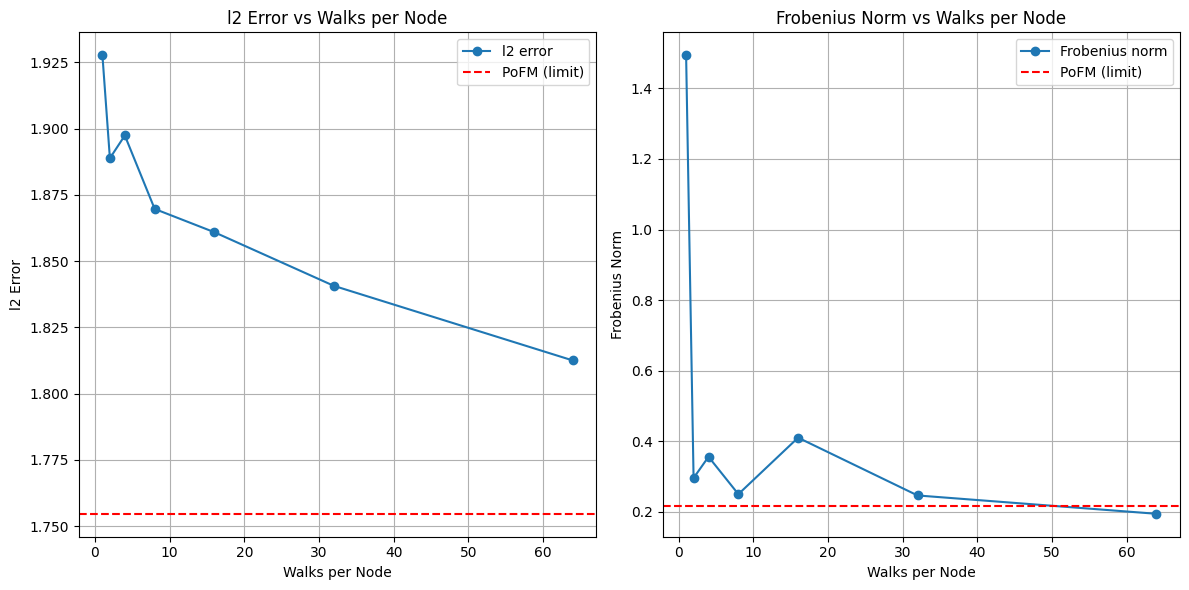

In [26]:
# Extract data for plotting
walks_per_node = [entry['walks_per_node'] for entry in results if entry['walks_per_node'] != 'PoFM']
l2_errors = [entry['l2_error'] for entry in results if entry['walks_per_node'] != 'PoFM']
fro_errors = [entry['fro_error'] for entry in results if entry['walks_per_node'] != 'PoFM']
pofm_l2_error = next(entry['l2_error'] for entry in results if entry['walks_per_node'] == 'PoFM')
pofm_fro_error = next(entry['fro_error'] for entry in results if entry['walks_per_node'] == 'PoFM')

# Plot l2 error
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(walks_per_node, l2_errors, marker='o', label='l2 error')
plt.axhline(y=pofm_l2_error, color='r', linestyle='--', label='PoFM (limit)')
plt.xlabel('Walks per Node')
plt.ylabel('l2 Error')
plt.title('l2 Error vs Walks per Node')
plt.legend()
plt.grid(True)

# Plot Frobenius norm
plt.subplot(1, 2, 2)
plt.plot(walks_per_node, fro_errors, marker='o', label='Frobenius norm')
plt.axhline(y=pofm_fro_error, color='r', linestyle='--', label='PoFM (limit)')
plt.xlabel('Walks per Node')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm vs Walks per Node')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Performance of the GRF Kernel with Arbitrary Modulation Function